In [1]:
device='cuda:0'

#general
import torch
import os
from copy import deepcopy


#Pruner
from circuit_pruner.force import *
from circuit_pruner.utils import load_config


#dataloader
import torch.utils.data as data
import torchvision.datasets as datasets
from circuit_pruner.data_loading import rank_image_data, single_image_data
from circuit_pruner.dissected_Conv2d import *


In [2]:
from torchvision.models import alexnet

model = alexnet(pretrained=True)
shape_model = alexnet(pretrained=True)

shape_dict = torch.load('models/shape_alexnet_statedict.pt')
shape_model.load_state_dict(shape_dict['state_dict'])

dis_model = dissect_model(deepcopy(model), store_activations = False, store_ranks = False, device=device)
dis_shape_model = dissect_model(deepcopy(shape_model), store_activations = False, store_ranks = False, device=device)

dis_model = dis_model.to(device).eval()
dis_shape_model = dis_shape_model.to(device).eval()

/home/chris/miniconda3/envs/circuit_pruner/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


### visualizations

In [3]:
from lucent_fresh.optvis import render, param, transform, objectives
from lucent_fresh.modelzoo.util import get_model_layers


In [ ]:
# for i in range(10):

#     obj  = objectives.neuron('features_10',i)
#     _ = render.render_vis(dis_model,  obj, show_inline=True)
#     _ = render.render_vis(dis_shape_model,  obj, show_inline=True)



### simple kernel spatial cosine similarity

In [4]:
layer = 3
layer_name = 'features_'+str(layer)
unit = 21

100%|██████████| 512/512 [00:18<00:00, 28.36it/s]



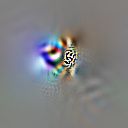

100%|██████████| 512/512 [00:18<00:00, 28.42it/s]



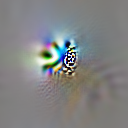

In [5]:

obj  = objectives.neuron('features_%s'%str(layer),unit)
_ = render.render_vis(dis_model,  obj, show_inline=True)
viz_im = render.render_vis(dis_shape_model,  obj, show_inline=True)


In [11]:
from circuit_pruner.receptive_fields import receptive_field, receptive_field_for_unit
from PIL import Image, ImageOps

model = model.to(device).eval()
#calculate analytical receptive field generative params for full model
#all_recep_field_params = receptive_field(model.features, (3,224,224))   #takes model (features, cant handle linear modules) and input image size



def featviz_in_recep_field(model,layer_name,unit, input_dim = (3,224,224)):
    from circuit_pruner.receptive_fields import receptive_field, receptive_field_for_unit
    from math import ceil, floor
    all_recep_field_params = receptive_field(model.features, input_dim)
    
    param_f = lambda: param.image(input_dim[1])
    obj  = objectives.neuron(layer_name,unit)
    viz_im = render.render_vis(dis_model,  obj, param_f, show_inline=True)
    
    layer_ind = str(int(layer_name.replace('features_',''))+1)
    map_size = (all_recep_field_params[layer_ind]['output_shape'][2],all_recep_field_params[layer_ind]['output_shape'][3])
    print(map_size)
    if map_size[0]%2 == 0:
        target_position = (int(map_size[0]/2+1),int(map_size[1]/2+1))
    else:
        target_position = (int(floor(map_size[0]/2)),int(floor(map_size[1]/2)))
    print(target_position)
    recep_field = receptive_field_for_unit(all_recep_field_params, layer_name, target_position)
    print(recep_field)
    viz_im = viz_im[0][:,int(recep_field[0][0]):int(recep_field[0][1]),int(recep_field[1][0]):int(recep_field[1][1]),:]
    #viz_im = viz_im[0][:,:,:,:]
    image = (viz_im * 255).astype(np.uint8)
    if len(image.shape) == 4:
        image = np.concatenate(image, axis=1)
    image = Image.fromarray(image)

    return image
    
    

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1               [55, 55]        3.5        4.0            11.0 
        2               [55, 55]        3.5        4.0            11.0 
        3               [27, 27]        7.5        8.0            19.0 
        4               [27, 27]        7.5        8.0            51.0 
        5               [27, 27]        7.5        8.0            51.0 
        6               [13, 13]       15.5       16.0            67.0 
        7               [13, 13]       15.5       16.0            99.0 
        8               [13, 13]       15.5       16.0            99.0 
        9               [13, 13]       15.5       16.0           131.0 
        10              [13, 13]       15.5       16.0           131.0 
        11              [13, 13]       15.5       16.0   

100%|██████████| 512/512 [00:18<00:00, 27.22it/s]



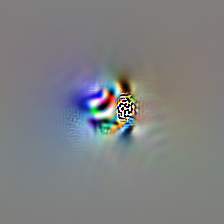

(27, 27)
(13, 13)
[(86.0, 137.0), (86.0, 137.0)]


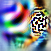

In [12]:
image = featviz_in_recep_field(model,layer_name,unit)
image

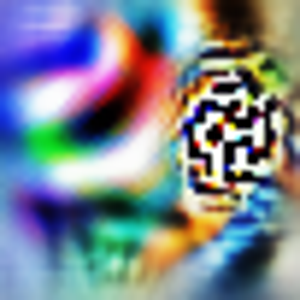

In [13]:
image = image.resize((300,300))
image

In [14]:
import plotly.express as px

featviz_fig = px.imshow(image)

In [15]:
feature = model.features[layer].weight[unit]
feature_flatweight = torch.reshape(feature, (feature.shape[0], feature.shape[1]*feature.shape[2]))

shape_feature = shape_model.features[layer].weight[unit]
shape_feature_flatweight = torch.reshape(shape_feature, (feature.shape[0], feature.shape[1]*feature.shape[2]))

In [40]:
cos = nn.CosineSimilarity(dim=0)

feature_matrix = []
for i in range(int(feature_flatweight.shape[-1])):
    feature_matrix.append([])
    for j in range(int(feature_flatweight.shape[-1])):
        out = cos(feature_flatweight[:,i],feature_flatweight[:,j])
        feature_matrix[-1].append(float(out))
        
shape_feature_matrix = []
for i in range(int(shape_feature_flatweight.shape[-1])):
    shape_feature_matrix.append([])
    for j in range(int(shape_feature_flatweight.shape[-1])):
        out = cos(shape_feature_flatweight[:,i],shape_feature_flatweight[:,j])
        shape_feature_matrix[-1].append(float(out))
               
            
feature_matrix = np.array(feature_matrix).transpose()

In [17]:
kernel_avg = torch.sum(feature,dim=0).detach().to('cpu').numpy()

kernel_size = kernel_avg.shape[0]

In [27]:
import plotly.express as px
import plotly.graph_objects as go

# fig_kernel_avg = px.imshow(kernel_avg,color_continuous_scale='RdBu_r')      
# fig_kernel_avg.add_trace(go.Scatter(x=[0], y=[0], marker=dict(color='white', size=20,line=dict(width=2,color='black'))))
# fig_kernel_avg.add_trace(go.Scatter(x=[0], y=[0], marker=dict(color='black', size=20,line=dict(width=2,color='black'))))


# fig_kernel_avg.update_layout({
# 'plot_bgcolor': 'rgba(0, 0, 0, 0)',
# 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
# 'showlegend':False
# })


# fig_kernel_avg.show()


z = kernel_avg
fig_kernel_avg = go.Figure(data=go.Heatmap(
                                            z = z,
                                            type = 'heatmap',
                                            colorscale = 'RdBu_r',
                                            zmid=0),
                           
                          layout = go.Layout(yaxis=dict(scaleanchor="x", scaleratio=1),
                                             yaxis_range=[len(kernel_avg),-2],
                                             xaxis_range=[-1,len(kernel_avg[0])+.5],
                                             plot_bgcolor='rgba(0, 0, 0, 0)',
                                             paper_bgcolor='rgba(0, 0, 0, 0)',
                                             width = 550,
                                             height = 500,
                                             showlegend=False)
                          )


fig_kernel_avg.add_trace(go.Scatter(x=[0], y=[0], marker=dict(color='white', size=20,line=dict(width=2,color='black'))))
fig_kernel_avg.add_trace(go.Scatter(x=[0], y=[0], marker=dict(color='black', size=20,line=dict(width=2,color='black'))))


fig_kernel_avg.update_yaxes(visible=False)
fig_kernel_avg.update_xaxes(visible=False)

fig_kernel_avg.show()

In [41]:
import plotly.express as px



# fig_cosim = px.imshow(feature_matrix, color_continuous_scale='RdBu_r')

# x_leger_pos = (int(len(feature_matrix)/2),-4)
# y_leger_pos = (len(feature_matrix)+3,int(len(feature_matrix)/2))

# fig_cosim.add_trace(go.Scatter(x=[x_leger_pos[0]], y=[x_leger_pos[1]], marker=dict(color='white', size=20,line=dict(width=2,color='black'))))
# fig_cosim.add_trace(go.Scatter(x=[y_leger_pos[0]], y=[y_leger_pos[1]], marker=dict(color='black', size=20,line=dict(width=2,color='black'))))


# fig_cosim.update_layout({
# 'plot_bgcolor': 'rgba(0, 0, 0, 0)',
# 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
# 'showlegend':False
# })


# fig_cosim.show()



z = feature_matrix
fig_cosim = go.Figure(data=go.Heatmap(
                                            z = z,
                                            type = 'heatmap',
                                            colorscale = 'RdBu_r',
                                            zmid=0),
                           
                          layout = go.Layout(yaxis=dict(scaleanchor="x", scaleratio=1),
                                             yaxis_range=[len(feature_matrix),-2],
                                             xaxis_range=[-1,len(feature_matrix[0])+.5],
                                             plot_bgcolor='rgba(0, 0, 0, 0)',
                                             paper_bgcolor='rgba(0, 0, 0, 0)',
                                             width = 550,
                                             height = 500,
                                             showlegend=False)
                          )


x_leger_pos = (int(len(feature_matrix)/2),-1.5)
y_leger_pos = (len(feature_matrix)+.5,int(len(feature_matrix)/2))

fig_cosim.add_trace(go.Scatter(x=[x_leger_pos[0]], y=[x_leger_pos[1]], marker=dict(color='white', size=20,line=dict(width=2,color='black'))))
fig_cosim.add_trace(go.Scatter(x=[y_leger_pos[0]], y=[y_leger_pos[1]], marker=dict(color='black', size=20,line=dict(width=2,color='black'))))

fig_cosim.update_yaxes(visible=False)
fig_cosim.update_xaxes(visible=False)

fig_cosim.show()


In [43]:
import plotly.graph_objects as go # or plotly.express as px

import json
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State


#external_stylesheets = ['https://codepen.io/amyoshino/pen/jzXypZ.css']
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

styles = {
    'pre': {
        'border': 'thin lightgrey solid',
        'overflowX': 'scroll'
    }
}


app = dash.Dash(external_stylesheets = external_stylesheets)


app.layout = html.Div([
        html.Div(
            children = [

            #Image
            html.Div(
                children = [

                html.Label('%s:%s'%(layer_name,str(unit))),
                dcc.Graph(
                    id='deepviz-image',
                    figure=featviz_fig,
                    config={
                            'displayModeBar': False
                            }
                ),

                ], className="three columns",
                ),
                
            #kernel
            html.Div(
                children = [

                html.Label('average input kernel'),
                dcc.Graph(
                    id='avg-kernel',
                    figure=fig_kernel_avg,
                    config={
                            'displayModeBar': False
                            }
                ),

                ], className="four columns",
                ),
                
            #kernel sim matrix
            html.Div(
                children = [

                html.Label('positional similarity'),
                dcc.Graph(
                    id='sim-mat',
                    figure=fig_cosim,
                    config={
                            'displayModeBar': False
                            }
                ),

                ], className="five columns",
                )
                 
            ], className="row"
        ),
    
    ])  
    
#     #Plotting data showing
#     html.Div(className='row', children=[
#         html.Div([
#             dcc.Markdown("""
#                 **Hover Data**

#                 Mouse over values in the graph.
#             """),
#             html.Pre(id='hover-data', style=styles['pre'])
#         ], className='three columns'),

#         html.Div([
#             dcc.Markdown("""
#                 **Click Data**

#                 Click on points in the graph.
#             """),
#             html.Pre(id='click-data', style=styles['pre']),
#         ], className='three columns'),

#         html.Div([
#             dcc.Markdown("""
#                 **Selection Data**

#                 Choose the lasso or rectangle tool in the graph's menu
#                 bar and then select points in the graph.

#                 Note that if `layout.clickmode = 'event+select'`, selection data also
#                 accumulates (or un-accumulates) selected data if you hold down the shift
#                 button while clicking.
#             """),
#             html.Pre(id='selected-data', style=styles['pre']),
#         ], className='three columns'),

#         html.Div([
#             dcc.Markdown("""
#                 **Zoom and Relayout Data**

#                 Click and drag on the graph to zoom or click on the zoom
#                 buttons in the graph's menu bar.
#                 Clicking on legend items will also fire
#                 this event.
#             """),
#             html.Pre(id='relayout-data', style=styles['pre']),
#         ], className='three columns')
#     ])
# ])

@app.callback(
    Output('avg-kernel', 'figure'),
    Input('sim-mat', 'hoverData'),
    [State('avg-kernel','figure')])
def display_kernel_pos_from_hoverdata(hoverData,fig):
    fig['data'][1]['x'] = [hoverData["points"][0]['x'] % kernel_size ] 
    fig['data'][1]['y'] = [hoverData["points"][0]['x'] // kernel_size ] 
    fig['data'][2]['x'] = [hoverData["points"][0]['y'] % kernel_size ] 
    fig['data'][2]['y'] = [hoverData["points"][0]['y'] // kernel_size ] 

    return fig



#
# @app.callback(
#     Output('deepviz-image', 'figure'),
#     Input('sim-mat', 'hoverData'),
#     [State('deepviz-image', 'figure')])
# def display_recepfield_from_hoverdata(hoverData,image_fig): 
#         #nodeid = node_actmap_fig['data'][0]['name']
#         layer_name = nodeid_2_perlayerid(nodeid,params)[2]
#         if layer_name == 'img':
#             raise Exception('no receptive fields for input image actmap')
#         heatmap_dim_y = len(node_actmap_fig['data'][0]['z'])
#         heatmap_dim_x = len(node_actmap_fig['data'][0]['z'][0]) 
#         x_click = click_data['points'][0]['x']
#         y_click = heatmap_dim_y - click_data['points'][0]['y']-1
#         print('x_click')
#         print(x_click)
#         print('y_click')
#         print(y_click)
#         recep_field = receptive_field_for_unit(receptive_fields, layer_name, (x_click,y_click))
#         recep_field_normed = [[recep_field[0][0]*10/input_image_size,recep_field[0][1]*10/input_image_size],
#                               [recep_field[1][0]*10/input_image_size,recep_field[1][1]*10/input_image_size]]
#         print('normalized')
#         print(recep_field_normed)
#         x_points = [recep_field_normed[0][0],recep_field_normed[0][0],recep_field_normed[0][1],recep_field_normed[0][1],recep_field_normed[0][0]]
#         y_points = [10 - recep_field_normed[1][0],10 - recep_field_normed[1][1],10 - recep_field_normed[1][1],10 - recep_field_normed[1][0],10 - recep_field_normed[1][0]]
#         print('x points')
#         print(x_points)
#         print('y points')
#         print(y_points)
#         image_fig['data'] = [{'mode': 'lines', 'x': x_points, 'y': y_points, 'type': 'scatter','line':{'color':'red'}}]
#         return image_fig





@app.callback(
    Output('hover-data', 'children'),
    Input('sim-mat', 'hoverData'))
def display_hover_data(hoverData):
    return json.dumps(hoverData, indent=2)


@app.callback(
    Output('click-data', 'children'),
    Input('sim-mat', 'clickData'))
def display_click_data(clickData):
    return json.dumps(clickData, indent=2)


@app.callback(
    Output('selected-data', 'children'),
    Input('sim-mat', 'selectedData'))
def display_selected_data(selectedData):
    return json.dumps(selectedData, indent=2)


@app.callback(
    Output('relayout-data', 'children'),
    Input('sim-mat', 'relayoutData'))
def display_relayout_data(relayoutData):
    return json.dumps(relayoutData, indent=2)


    
    
 



# #kernel dots
# @app.callback(
#     Output('node-actmap-dropdown', 'value'),
#     [Input('network-graph', 'clickData')],
#     [State('node-actmap-dropdown', 'value')])
# def switch_node_actmap_click(clickData,current_value):
#     print('CALLED: switch_node_actmap_click')
#     if clickData is None:
#         return current_value 
#         #raise Exception('no click data')
#     if int(clickData['points'][0]['curveNumber']) > params['num_layers']:
#         return current_value
#         #raise Exception('edge was clicked')
#     return clickData['points'][0]['text']


app.run_server(port=8878)

Dash is running on http://127.0.0.1:8878/

Dash is running on http://127.0.0.1:8878/

Dash is running on http://127.0.0.1:8878/

Dash is running on http://127.0.0.1:8878/

Dash is running on http://127.0.0.1:8878/

Dash is running on http://127.0.0.1:8878/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8878/ (Press CTRL+C to quit)
127.0.0.1 - - [06/Jul/2022 14:20:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:55] "GET /_dash-component-suites/dash_renderer/react@16.v1_9_1m1617985068.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:55] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_9_1m1617985068.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:55] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_9_1m1617985068.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:55] "GET /_dash-component-suites/dash_core_components/dash_core_components-shared.v1_16_0m1617985098.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:55] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_9_1m1617985068.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:55] "GET /_dash-component-suites/dash_core_components/dash_core_components.v1_16_0m1617985098.min.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 1

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/circuit_pruner/lib/python3.7/site-packages/flask/app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/circuit_pruner/lib/python3.7/site-packages/flask/app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/circuit_pruner/lib/python3.7/site-packages/flask/app.py", line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/circuit_pruner/lib/python3.7/site-packages/flask/app.py", line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/circuit_pruner/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/circuit

127.0.0.1 - - [06/Jul/2022 14:20:56] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [06/Jul/2022 14:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:20:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:21:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:21:02] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:21:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.

127.0.0.1 - - [06/Jul/2022 14:37:00] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:37:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.

127.0.0.1 - - [06/Jul/2022 14:39:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:39:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:39:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:39:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:39:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:39:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:39:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:39:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:39:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:39:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:39:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2022 14:39:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.

In [78]:
import plotly.express as px

# fig_shape_cosim = px.imshow(shape_feature_matrix, color_continuous_scale='RdBu_r')

# x_leger_pos = (int(len(feature_matrix)/2),-4)
# y_leger_pos = (len(feature_matrix)+3,int(len(feature_matrix)/2))

# fig_shape_cosim.add_trace(go.Scatter(x=[x_leger_pos[0]], y=[x_leger_pos[1]], marker=dict(color='white', size=20,line=dict(width=2,color='black'))))
# fig_shape_cosim.add_trace(go.Scatter(x=[y_leger_pos[0]], y=[y_leger_pos[1]], marker=dict(color='black', size=20,line=dict(width=2,color='black'))))


# fig_shape_cosim.update_layout({
# 'plot_bgcolor': 'rgba(0, 0, 0, 0)',
# 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
# })


z = shape_feature_matrix
fig_shape_cosim = go.Figure(data=go.Heatmap(
                                            z = z,
                                            type = 'heatmap',
                                            colorscale = 'RdBu_r',
                                            zmid=0),
                           
                          layout = go.Layout(yaxis=dict(scaleanchor="x", scaleratio=1),
                                             yaxis_range=[len(feature_matrix),-2],
                                             xaxis_range=[-1,len(feature_matrix[0])+.5],
                                             plot_bgcolor='rgba(0, 0, 0, 0)',
                                             paper_bgcolor='rgba(0, 0, 0, 0)',
                                             width = 550,
                                             height = 500,
                                             showlegend=False)
                          )


x_leger_pos = (int(len(feature_matrix)/2),-1.5)
y_leger_pos = (len(feature_matrix)+.5,int(len(feature_matrix)/2))

fig_shape_cosim.add_trace(go.Scatter(x=[x_leger_pos[0]], y=[x_leger_pos[1]], marker=dict(color='white', size=20,line=dict(width=2,color='black'))))
fig_shape_cosim.add_trace(go.Scatter(x=[y_leger_pos[0]], y=[y_leger_pos[1]], marker=dict(color='black', size=20,line=dict(width=2,color='black'))))

fig_shape_cosim.update_yaxes(visible=False)
fig_shape_cosim.update_xaxes(visible=False)

fig_shape_cosim.show()

In [66]:
#diff matrix
import numpy as np
import plotly.express as px

#fig_dif_comsim = px.imshow(np.array(feature_matrix)-np.array(shape_feature_matrix), color_continuous_scale='RdBu_r',zmid=0)
#fig_dif_comsim.show()

z = np.array(feature_matrix)-np.array(shape_feature_matrix)
fig_dif_comsim = go.Figure(data=go.Heatmap(
                                            z = z,
                                            type = 'heatmap',
                                            colorscale = 'RdBu_r',
                                            zmid=0),
                           
                          layout = go.Layout(yaxis=dict(scaleanchor="x", scaleratio=1),
                                             yaxis_range=[-1,len(feature_matrix)],
                                             xaxis_range=[-1,len(feature_matrix[0])],
                                             plot_bgcolor='rgba(0, 0, 0, 0)',
                                             paper_bgcolor='rgba(0, 0, 0, 0)',
                                             width = 550,
                                             height = 500)
                          )




fig_dif_comsim.show()

